Project: Cosmology
==================

This project uses the astrophysical phenomena of Strong Gravitational Lensing to illustrate multi-level model
composition and fitting with **PyAutoFit**.

A strong gravitational lens is a system where two (or more) galaxies align perfectly down our line of sight from Earth
such that the foreground galaxy's mass deflects the light of a background source galaxy(s).

When the alignment is just right and the lens is massive enough, the background source galaxy appears multiple
times. The schematic below shows such a system, where light-rays from the source are deflected around the lens galaxy
to the observer following multiple distinct paths.

![Schematic of Gravitational Lensing](https://raw.githubusercontent.com/Jammy2211/PyAutoLens/main/docs/overview/images/overview_1_lensing/schematic.jpg)
**Credit: F. Courbin, S. G. Djorgovski, G. Meylan, et al., Caltech / EPFL / WMKO**
https://www.cosmology.caltech.edu/~george/qsolens/

As an observer, we don't see the source's true appearance (e.g. the red round blob of light). We only observe its
light after it has been deflected and lensed by the foreground galaxies (e.g. as the two distinct red multiple images
 in the image on the left). We also observe the emission of the foreground galaxy (in blue).

You can read more about gravitational lensing as the following link:

https://en.wikipedia.org/wiki/Gravitational_lens

__PyAutoLens__

Strong gravitational lensing is the original science case that sparked the development of **PyAutoFit**, which is
a spin off of our astronomy software **PyAutoLens** `https://github.com/Jammy2211/PyAutoLens`.

We'll use **PyAutoLens** to illustrate how the tools we developed with **PyAutoFit** allowed us to
ensure **PyAutoLens**'s model fitting tools were extensible, easy to maintain and enabled intuitive model composition.

__Multi-Level Models__

Strong lensing is a great case study for using **PyAutoFit**, due to the multi-component nature of how one composes
a strong lens model. A strong lens model consists of light and mass models of each galaxy in the lens system, where
each galaxy is a model in itself. The galaxies are combined into one overall "lens model", which in later tutorials
we will show may also have a Cosmological model.

This example project uses **PyAutoFit** to compose and fit models of a strong lens, in particular highlighting
**PyAutoFits** multi-level model composition.

__Strong Lens Modeling__

The models are fitted to Hubble Space Telescope imaging of a real strong lens system and will allow us to come up
with a description of how light is deflected on its path through the Universe.

This project consists of two example scripts / notebooks:

 1) `example_1_intro`: An introduction to strong lensing, and the various parts of the project's source code that are
    used to represent a strong lens galaxy.

 2) `example_2_multi_level_model`: Using **PyAutoFit** to model a strong lens, with a strong emphasis on the
    multi-level model API.

__This Example__

This introduction primarily focuses on what strong lensing is, how we define the individual model-components and fit
a strong lens model to data. It does not make much use of **PyAutoFit**, but it does provide a clear understanding of
the model so that **PyAutoFit**'s use in example 2 is clear.

Note that import `import src as cosmo`. The package `src` contains all the code we need for this example Cosmology
use case, and can be thought of as the source-code you would write to perform model-fitting via **PyAutoFit** for your
problem of interest.

The module `src/__init__.py` performs a series of imports that are used throughout this lecture to provide convenient
access to different parts of the source code.

In [59]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import src as cosmo
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from os import path

import autofit as af

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Plot__

We will plot a lot of arrays of 2D data and grids of 2D coordinates in this example, so lets make a convenience 
functions.

In [60]:


def plot_array(array, title=None, norm=None):
    plt.imshow(array, norm=norm)
    plt.colorbar()
    plt.title(title)
    plt.show()
    plt.close()


def plot_grid(grid, title=None):
    plt.scatter(x=grid[:, :, 0], y=grid[:, :, 1], s=1)
    plt.title(title)
    plt.show()
    plt.close()


__Data__

First, lets load and plot Hubble Space Telescope imaging data of the strong gravitational lens called SDSSJ2303+1422, 
where this data includes:

 1) The image of the strong lens, which is the data we'll fit.
 2) The noise in every pixel of this image, which will be used when evaluating the log likelihood.

__Masking__

When fitting 2D imaging data, it is common to apply a mask which removes regions of the image that are not relevant to
the model fitting.

For example, when fitting the strong lens, we remove the edges of the image where the lens and source galaxy's light is 
not visible.

In the strong lens image and noise map below, you can see this has already been performed, with the edge regions
blank.

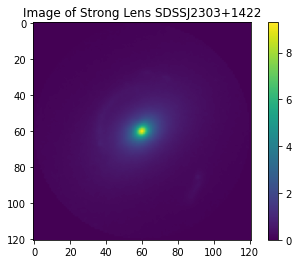

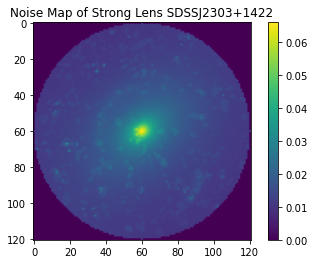

In [61]:
dataset_path = path.join("dataset", "cosmology")

data = np.load(file=path.join(dataset_path, "data.npy"))
plot_array(array=data, title="Image of Strong Lens SDSSJ2303+1422")

noise_map = np.load(file=path.join(dataset_path, "noise_map.npy"))
plot_array(array=noise_map, title="Noise Map of Strong Lens SDSSJ2303+1422")

In the image of the strong lens two distinct objects can be seen:

 1) A central blob of light, corresponding to the foreground lens galaxy whose mass is responsible for deflecting light.
 2) Two faint arcs of light in the bakcground, which is the lensed background source.

__PSF__

Another component of imaging data is the Point Spread Function (PSF), which describes how the light of the galaxies
are blurred when they enter the Huble Space Telescope's. 

This is because diffraction occurs when the light enters HST's optics, causing the light to smear out. The PSF is
a two dimensional array that describes this blurring via a 2D convolution kernel.

When fitting the data below and in the `log_likelihood_function`, you'll see that the PSF is used when creating the 
model data. This is an example of how an `Analysis` class may be extended to include additional steps in the model
fitting procedure.

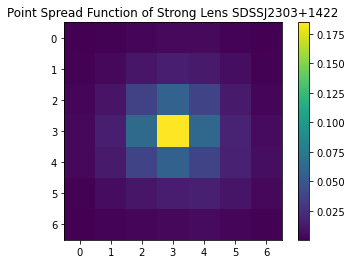

In [62]:
psf = np.load(file=path.join(dataset_path, "psf.npy"))
plot_array(array=psf, title="Point Spread Function of Strong Lens SDSSJ2303+1422")

__Grid__

To perform strong lensing, we need a grid of (x,y) coordinates which we map throughout the Universe as if their path
is deflected. 

For this, we create a simple 2D grid of coordinates below where the origin is (0.0, 0.0) and the size of
a pixel is 0.05, which corresponds to the resolution of our image `data`. 

This grid only contains (y,x) coordinates within the cricular mask that was applied to the data, as we only need to
perform ray-tracing within this region.

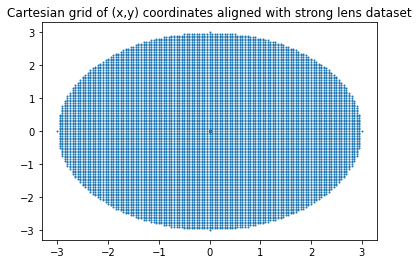

In [63]:
grid = np.load(file=path.join(dataset_path, "grid.npy"))

plot_grid(
    grid=grid,
    title="Cartesian grid of (x,y) coordinates aligned with strong lens dataset",
)

__Light Profiles__

Our model of a strong lens must include a description of the light of each galaxy, which we call a "light profile".
In the source-code of this example project, specifically the module `src/light_profiles.py` you will see there
are two light profile classes named `LightDeVaucouleurs` and `LightExponential`.

These Python classes are the model components we will use to represent each galaxy's light and they behave analogous 
to the `Gaussian` class seen in other tutorials. The input parameters of their `__init__` constructor (e.g. `centre`, 
`axis_ratio`, `angle`) are their model parameters that may be fitted for by a non-linear search.

These classes also contain functions which create an image from the light profile if an input grid of (x,y) 2D 
coordinates are input, which we use below to create an image of a light profile.

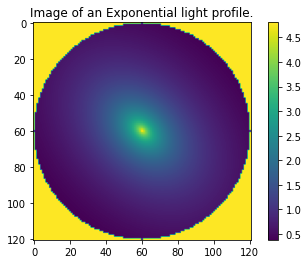

In [64]:
light_profile = cosmo.lp.LightExponential(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, intensity=1.0, effective_radius=2.0
)
light_image = light_profile.image_from_grid(grid=grid)

plot_array(array=light_image, title="Image of an Exponential light profile.")

__Mass Profiles__

Our model also includes the mass of the foreground lens galaxy, called a 'mass profile'. In the source-code of the 
example project, specifically the module `src/mass_profiles.py` you will see there is a mass profile class named 
`MassIsothermal`. Like the light profile, this will be a model-component **PyAutoFit** fits via a non-linear search.

The class also contains functions which create the "deflections angles", which describe the angles by which light is 
deflected when it passes the mass of the foreground lens galaxy. These are subtracted from the (y,x) grid above to
determine the original coordinates of the source galaxy before lensing.

A higher mass galaxy, which bends light more, will have higher values of the deflection angles plotted below:

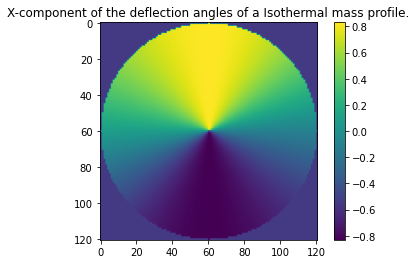

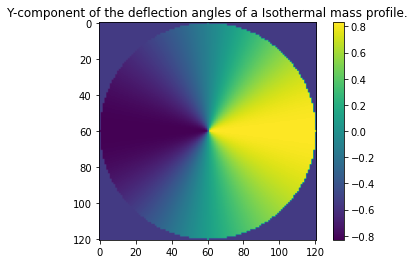

In [65]:
mass_profile = cosmo.mp.MassIsothermal(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, mass=0.5
)
mass_deflections = mass_profile.deflections_from_grid(grid=grid)

plot_array(
    array=mass_deflections[:, :, 0],
    title="X-component of the deflection angles of a Isothermal mass profile.",
)
plot_array(
    array=mass_deflections[:, :, 1],
    title="Y-component of the deflection angles of a Isothermal mass profile.",
)

__Ray Tracing__

The deflection angles describe how our (x,y) grid of coordinates are deflected by the mass of the foreground galaxy.

We can therefore ray-trace the grid aligned with SDSSJ2303+1422 using the mass profile above and plot a grid of
coordinates in the reference frame of before their light is gravitationally lensed:

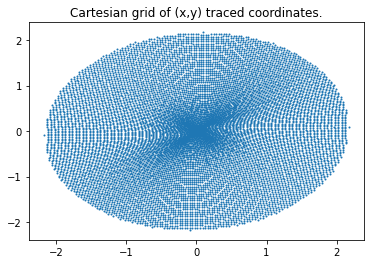

In [66]:
traced_grid = grid - mass_deflections

plot_grid(grid=traced_grid, title="Cartesian grid of (x,y) traced coordinates.")

By inputting this traced grid of (x,y) coordinates into our light profile, we can create an image of the galaxy as if
it were gravitationally lensed by the mass profile.

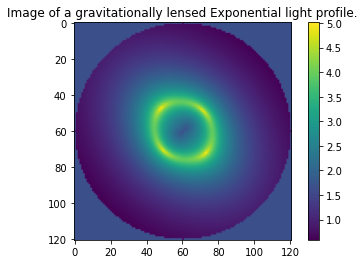

In [67]:
traced_light_image = light_profile.image_from_grid(grid=traced_grid)

plot_array(
    array=traced_light_image,
    title="Image of a gravitationally lensed Exponential light profile.",
)

__Galaxy__

In the `src/galaxy.py` module we define the `Galaxy` class, which is a collection of light and mass profiles at an 
input redshift. For strong lens modeling, we have to use `Galaxy` objects, as the redshifts define how ray-tracing is
performed.

Below, we create two instances of the `Galaxy` class, representing the lens and source galaxies in a strong lens system.

In [68]:
light_profile = cosmo.lp.LightDeVaucouleurs(
    centre=(0.01, 0.01), axis_ratio=0.9, angle=45.0, intensity=0.1, effective_radius=1.0
)
mass_profile = cosmo.mp.MassIsothermal(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, mass=0.8
)
lens_galaxy = cosmo.Galaxy(
    redshift=0.5, light_profile_list=[light_profile], mass_profile_list=[mass_profile]
)

light_profile = cosmo.lp.LightExponential(
    centre=(0.1, 0.1), axis_ratio=0.5, angle=80.0, intensity=1.0, effective_radius=5.0
)
source_galaxy = cosmo.Galaxy(
    redshift=0.5, light_profile_list=[light_profile], mass_profile_list=[mass_profile]
)

A galaxy's image is the sum of its light profile images, and its deflection angles are the sum of its mass profile
deflection angles.

To illustrate this, lets plot the lens galaxy's light profile image:

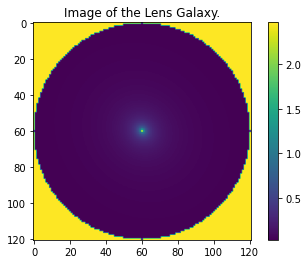

In [69]:
galaxy_image = lens_galaxy.image_from_grid(grid=grid)

plot_array(array=galaxy_image, title="Image of the Lens Galaxy.")

__Data Fitting__

We can create an overall image of the strong lens by:

 1) Creating an image of the lens galaxy.
 2) Computing the deflection angles of the lens galaxy.
 3) Ray-tracing light to the source galaxy reference frame and using its light profile to make its image.

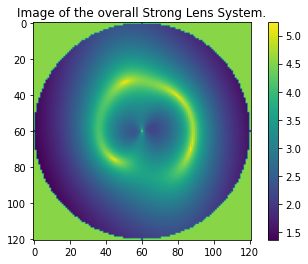

In [70]:
lens_image = lens_galaxy.image_from_grid(grid=grid)
lens_deflections = lens_galaxy.deflections_from_grid(grid=grid)

traced_grid = grid - lens_deflections

source_image = source_galaxy.image_from_grid(grid=traced_grid)

overall_image = lens_image + source_image

# The grid has zeros at its edges, which produce nans in the model image.
# These lead to an ill-defined log likelihood, so we set them to zero.
overall_image = np.nan_to_num(overall_image)

plot_array(array=overall_image, title="Image of the overall Strong Lens System.")

__Model Data__

To produce the `model_data`, we now convolution the overall image with the Point Spread Function (PSF) of our
observations. This blurs the image to simulate the telescope optics and pixelization used to observe the image.

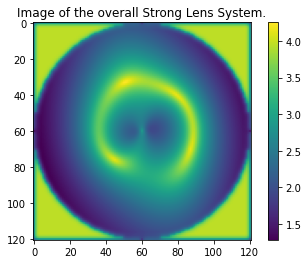

In [71]:
model_data = signal.convolve2d(
    overall_image, psf, mode="same"
)

plot_array(array=model_data, title="Image of the overall Strong Lens System.")

By subtracting this model image from the data, we can create a 2D residual map. This is equivalent to the residual maps
we made in the 1D Gaussian examples, except for 2D imaging data.

Clearly, the random lens model we used in this example does not provide a good fit to SDSSJ2303+1422.

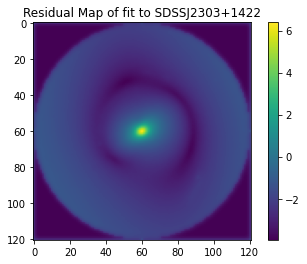

In [72]:
residual_map = data - model_data

plot_array(array=residual_map, title="Residual Map of fit to SDSSJ2303+1422")

Just like we did for the 1D `Gaussian` fitting examples, we can use the noise-map to compute the normalized residuals 
and chi-squared map of the lens model.

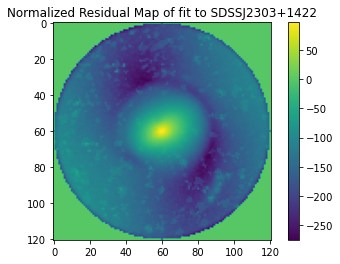

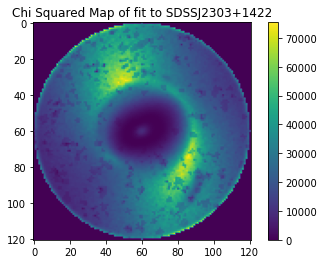

In [73]:
# The circular masking introduces zeros at the edge of the noise-map,
# which can lead to divide-by-zero errors.
# We set these values to 1.0e8, to ensure they do not contribute to the log likelihood.
noise_map_fit = noise_map
noise_map_fit[noise_map == 0] = 1.0e8

normalized_residual_map = residual_map / noise_map_fit
chi_squared_map = (normalized_residual_map) ** 2.0

plot_array(
    array=normalized_residual_map,
    title="Normalized Residual Map of fit to SDSSJ2303+1422",
)
plot_array(array=chi_squared_map, title="Chi Squared Map of fit to SDSSJ2303+1422")

Finally, we can compute the `log_likelihood` of this lens model, which we will use in the next example to fit the 
lens model to data with a non-linear search.

In [74]:
chi_squared = np.sum(chi_squared_map)
noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))

log_likelihood = -0.5 * (chi_squared + noise_normalization)

print(log_likelihood)

-142494071.85604835


__Wrap Up__

In this example, we introduced the astrophysical phenomena of strong gravitational lensing, and gave an overview of how
one can create a model for a strong lens system and fit it to imaging data. 

We ended by defining the log likelihood of the model-fit, which will form the `log_likelihood_function` of the
`Analysis` class we use in the next example, which fits this strong lens using **PyAutoFit**.

There is one thing you should think about, how would we translate the above classes (e.g. `LightExponential`, 
`MassIsothermal` and `Galaxy`) using the **PyAutoFit** `Model` and `Collection` objects? The `Galaxy` class contained 
instances of the light and mass profile classes, meaning the standard use of the `Model` and `Collection` objects could 
not handle this.

This is where multi-level models come in, as will be shown in the next example!

__Config__

We quickly set up some config files, which you don't need to worry about but ensure things run correctly.

In [75]:
import os
from os import path
from autoconf import conf

cwd = os.getcwd()
config_path = path.join(cwd, "config")
conf.instance.push(new_path=config_path)

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import src as cosmo
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Jammy\Code\PyAuto\precise_observational
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\precise_observational`


__Multi-level Model__

Above, we saw that we can use instances of the light profiles, mass profiles and galaxy objects to
perform strong lens ray-tracing calculations:

In [76]:
light_profile = cosmo.lp.LightDeVaucouleurs(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, intensity=1.0, effective_radius=2.0
)
mass_profile = cosmo.mp.MassIsothermal(
    centre=(0.01, 0.01), axis_ratio=0.7, angle=45.0, mass=0.5
)
galaxy = cosmo.Galaxy(
    redshift=0.5, light_profile_list=[light_profile], mass_profile_list=[mass_profile]
)

In this example, we want to perform a model-fit using a non-linear search, where the `Galaxy` is a `Model`, but it
contains model subcomponents that are its individual light and mass profiles. 

Here is a pictoral representation of the model:

![Strong Lens Model](https://github.com/rhayes777/PyAutoFit/blob/main/docs/overview/image/lens_model.png?raw=true "cluster")

__Model Composition__

How do we compose a strong lens model where a `Galaxy` is a `Model`, but it contains the light and mass profiles 
as `Model` themselves?

We use **PyAutoFit**'s multi-level model composition:

In [77]:
lens = af.Model(
    cls=cosmo.Galaxy,  # The overall model object uses this input.
    redshift=0.5,
    light_profile_list=[
        af.Model(cosmo.lp.LightDeVaucouleurs)
    ],  # These will be subcomponents of the model.
    mass_profile_list=[
        af.Model(cosmo.mp.MassIsothermal)
    ],  # These will be subcomponents of the model.
)

print(lens.info)

Total Free Parameters = 11

model                                                                           Galaxy (N=11)
    light_profile_list                                                          Collection (N=6)
        0                                                                       LightDeVaucouleurs (N=6)
    mass_profile_list                                                           Collection (N=5)
        0                                                                       MassIsothermal (N=5)

redshift                                                                        0.5
light_profile_list
    0
        centre
            centre_0                                                            GaussianPrior [127], mean = 0.0, sigma = 0.3
            centre_1                                                            GaussianPrior [128], mean = 0.0, sigma = 0.3
        axis_ratio                                                              UniformPrior [129], low

Lets consider what is going on here:

 1) We use a `Model` to create the overall model component. The `cls` input is the `Galaxy` class, therefore the 
    overall model that is created is a `Galaxy`.

 2) **PyAutoFit** next inspects whether the key word argument inputs to the `Model` match any of the `__init__` 
    constructor arguments of the `Galaxy` class. This determine if these inputs are to be composed as model 
    subcomponents of the overall `Galaxy` model. 

 3) **PyAutoFit** matches the `light_profile_list` and  `mass_profile_list` inputs, noting they are passed as separate 
    lists  containing the `LightDeVaucouleurs` and `MassIsothermal` class. They are both created as subcomponents of 
    the overall `Galaxy` model.

 4) It also matches the `redshift` input, making it a fixed value of 0.5 for the model and not treating it as a 
    free parameter.

We can confirm this by printing the `total_free_parameters` of the lens, and noting it is 11 (6 parameters for 
the `LightDeVaucouleurs` and 5 for the `MassIsothermal`).

In [78]:
print(lens.total_free_parameters)
print(lens.light_profile_list[0].total_free_parameters)
print(lens.mass_profile_list[0].total_free_parameters)

11
6
5


The `lens` behaves exactly like the model-components we are used to previously. For example, we can unpack its 
individual parameters to customize the model, where below we:

 1) Fix the light and mass profiles to the centre (0.0, 0.0).
 2) Customize the prior on the light profile `axis_ratio`.
 3) Fix the `axis_ratio` of the mass profile to 0.8.

In [79]:

lens.light_profile_list[0].centre = (0.0, 0.0)
lens.light_profile_list[0].axis_ratio = af.UniformPrior(
    lower_limit=0.7, upper_limit=0.9
)
lens.light_profile_list[0].angle = af.UniformPrior(lower_limit=0.0, upper_limit=180.0)
lens.light_profile_list[0].intensity = af.LogUniformPrior(lower_limit=1e-4, upper_limit=1e4)
lens.light_profile_list[0].effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

lens.mass_profile_list[0].centre = (0.0, 0.0)
lens.mass_profile_list[0].axis_ratio = 0.8
lens.mass_profile_list[0].angle = af.UniformPrior(lower_limit=0.0, upper_limit=180.0)
lens.mass_profile_list[0].mass = af.UniformPrior(lower_limit=0.0, upper_limit=2.0)

print(lens.info)

Total Free Parameters = 6

model                                                                           Galaxy (N=6)
    light_profile_list                                                          Collection (N=4)
        0                                                                       LightDeVaucouleurs (N=4)
    mass_profile_list                                                           Collection (N=2)
        0                                                                       MassIsothermal (N=2)

redshift                                                                        0.5
light_profile_list
    0
        centre                                                                  (0.0, 0.0)
        axis_ratio                                                              UniformPrior [138], lower_limit = 0.7, upper_limit = 0.9
        angle                                                                   UniformPrior [139], lower_limit = 0.0, upper_limit = 180.0
   

__Alternative API__

We can create the `Galaxy` model component with the exact same customization by creating each profile as a `Model` and
passing these to the galaxy `Model`.

Note that for a few parameters, priors are input which are near the high likelihood solutions, which I know based on analysing this strong lens previously. In a real analysis one would not have this knowledge and thus could not set the priors in this way. For this example, I do this simply to speed up the non-linear search

In [80]:
light = af.Model(cosmo.lp.LightDeVaucouleurs)

light.centre = (0.0, 0.0)
light.axis_ratio = af.UniformPrior(lower_limit=0.6, upper_limit=1.0)
light.angle = af.UniformPrior(lower_limit=0.0, upper_limit=180.0)
light.intensity = af.LogUniformPrior(lower_limit=1e-4, upper_limit=1e4)
light.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)

mass = af.Model(cosmo.mp.MassIsothermal)

mass.centre = (0.0, 0.0)
mass.axis_ratio = af.UniformPrior(lower_limit=0.6, upper_limit=1.0)
mass.angle = af.UniformPrior(lower_limit=0.0, upper_limit=180.0)
mass.mass = af.UniformPrior(lower_limit=1.0, upper_limit=2.0) # This is a prior I know from previous analysis

lens = af.Model(
    cosmo.Galaxy, redshift=0.5, light_profile_list=[light], mass_profile_list=[mass]
)

print(lens.info)

Total Free Parameters = 7

model                                                                           Galaxy (N=7)
    light_profile_list                                                          Collection (N=4)
        0                                                                       LightDeVaucouleurs (N=4)
    mass_profile_list                                                           Collection (N=3)
        0                                                                       MassIsothermal (N=3)

redshift                                                                        0.5
light_profile_list
    0
        centre                                                                  (0.0, 0.0)
        axis_ratio                                                              UniformPrior [150], lower_limit = 0.6, upper_limit = 1.0
        angle                                                                   UniformPrior [151], lower_limit = 0.0, upper_limit = 180.0
   

We can now create a model of our source galaxy using the same API.

In [81]:
light = af.Model(cosmo.lp.LightExponential)

light.centre.centre_0 = af.GaussianPrior(mean=-0.25, sigma=0.1) # This is a prior I know from previous analysis
light.centre.centre_1 = af.GaussianPrior(mean=0.33, sigma=0.1) # This is a prior I know from previous analysis
light.axis_ratio = af.UniformPrior(lower_limit=0.7, upper_limit=1.0)
light.angle = af.UniformPrior(lower_limit=0.0, upper_limit=180.0)
light.intensity = af.LogUniformPrior(lower_limit=1e-4, upper_limit=1e4)
light.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=1.0)

source = af.Model(
    cosmo.Galaxy, redshift=1.0, light_profile_list=[light]
)

print(source.info)







Total Free Parameters = 6

model                                                                           Galaxy (N=6)
    light_profile_list                                                          Collection (N=6)
        0                                                                       LightExponential (N=6)

redshift                                                                        1.0
light_profile_list
    0
        centre
            centre_0                                                            GaussianPrior [162], mean = -0.25, sigma = 0.1
            centre_1                                                            GaussianPrior [163], mean = 0.33, sigma = 0.1
        axis_ratio                                                              UniformPrior [164], lower_limit = 0.7, upper_limit = 1.0
        angle                                                                   UniformPrior [165], lower_limit = 0.0, upper_limit = 180.0
        intensity   

We can now create our overall strong lens model, using a `Collection` in the same way we have seen previously.

In [82]:
model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

print(model.info)

Total Free Parameters = 13

model                                                                           Collection (N=13)
    galaxies                                                                    Collection (N=13)
        lens                                                                    Galaxy (N=7)
            light_profile_list                                                  Collection (N=4)
                0                                                               LightDeVaucouleurs (N=4)
            mass_profile_list                                                   Collection (N=3)
                0                                                               MassIsothermal (N=3)
        source                                                                  Galaxy (N=6)
            light_profile_list                                                  Collection (N=6)
                0                                                               LightExponent

The model contains both galaxies in the strong lens, alongside all of their light and mass profiles.

For every iteration of the non-linear search **PyAutoFit** generates an instance of this model, where all of the
`LightDeVaucouleurs`, `MassIsothermal` and `Galaxy` parameters of the are determined via their priors. 

An example instance is show below:

In [83]:
instance = model.random_instance()

print("Strong Lens Model Instance:")
print("Lens Galaxy = ", instance.galaxies.lens)
print("Lens Galaxy Light = ", instance.galaxies.lens.light_profile_list)
print(
    "Lens Galaxy Light Centre = ", instance.galaxies.lens.light_profile_list[0].centre
)
print("Lens Galaxy Mass Centre = ", instance.galaxies.lens.mass_profile_list[0].centre)
print("Source Galaxy = ", instance.galaxies.source)

Strong Lens Model Instance:
Lens Galaxy =  <src.galaxy.Galaxy object at 0x000002B1F00C7FA0>
Lens Galaxy Light =  <autofit.mapper.model.ModelInstance object at 0x000002B1F00C7820>
Lens Galaxy Light Centre =  (0.0, 0.0)
Lens Galaxy Mass Centre =  (0.0, 0.0)
Source Galaxy =  <src.galaxy.Galaxy object at 0x000002B1F00C76A0>


We have successfully composed a multi-level model, which we can fit via a non-linear search.

At this point, you should check out the `Analysis` class of this example project, in the 
module `projects/cosmology/src/analysis.py`. This class serves the same purpose that we have seen in the Gaussian 1D 
examples, with the `log_likelihood_function` implementing the calculation we showed in the first tutorial.

The `path_prefix and `name` inputs below sepciify the path and folder where the results of the model-fit are stored
in the output folder. Results for this tutorial are written to hard-disk, due to the
longer run-times of the model-fit.

In [84]:
search = af.DynestyStatic(
    path_prefix=path.join("session_2"),
    name="lensing",
    nlive=250,
    sample="rwalk",
    iterations_per_update=3000
)

analysis = cosmo.Analysis(data=data, noise_map=noise_map, psf=psf, grid=grid)

2023-07-02 16:50:42,815 - autofit.non_linear.abstract_search - INFO - Creating search


If you comment out the code below, you will perform a lens model fit using the model and analysis class for 
this project. However, this model-fit is slow to run, and it isn't paramount that you run it yourself.

The animation below shows a slide-show of the lens modeling procedure. Many lens models are fitted to the data over
and over, gradually improving the quality of the fit to the data and looking more and more like the observed image.

![Lens Modeling Animation](https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true "model")

In [85]:
result = search.fit(model=model, analysis=analysis)

2023-07-02 16:50:42,831 - lensing - INFO - Starting search
2023-07-02 16:50:43,014 - lensing - INFO - Already completed, skipping non-linear search.
2023-07-02 16:50:47,360 - lensing - INFO - Removing zip file


Many different resulting images are available for this model-fit, including the model image of the strong lens, its residual-map and individual images of the lens and source galaxies.

Rather than plot all of these results in the notebook, checkout the `output/session_2` folder to see the results as .png files.

__Local Maxima__

In the previous session, we discussed how non-linear searches can become stuck in local maxima, failing to locate the highest
likelihood regions of parameter space.

We illustrate this using this lensing model example. We simply reduce the number of live points used by Dynesty to 25, which means it performs an extremely coarse sampling of parameter space. Owining to the reduced detail with which it samples parameter space, it becomes stuck in a local maxima, producing a lens model that is clearly rubbish.

Again, checkout the `output/session_2` folder to see the results as .png files.

In [ ]:
search = af.DynestyStatic(
    path_prefix=path.join("session_2"),
    name="lensing__local_maxima",
    nlive=25,
    sample="rwalk",
    iterations_per_update=3000
)

result = search.fit(model=model, analysis=analysis)

2023-07-02 16:50:50,273 - autofit.non_linear.abstract_search - INFO - Creating search
2023-07-02 16:50:50,275 - lensing__local_maxima - INFO - Starting search
2023-07-02 16:50:50,278 - lensing__local_maxima - INFO - Saving path info
2023-07-02 16:50:50,500 - lensing__local_maxima - INFO - Not complete. Starting non-linear search.
2023-07-02 16:50:50,506 - lensing__local_maxima - INFO - No Dynesty samples found, beginning new non-linear search. 
2023-07-02 16:50:57,014 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.


C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\anaconda3\envs\PyAuto\lib\site-packages\dynesty\dynesty.py:552: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn(
530it [00:17, 30.47it/s, +25 | bound: 118 | nc: 1 | ncall: 3053 | eff(%): 18.329 | loglstar:   -inf < -88258.938 <    inf | logz: -88282.577 +/-  0.666 | dlogz:  0.511 >  0.034]

2023-07-02 16:51:14,765 - lensing__local_maxima - INFO - 3000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
1131it [00:10, 110.69it/s, +25 | bound: 275 | nc: 1 | ncall: 6058 | eff(%): 19.161 | loglstar:   -inf < -79653.784 <    inf | logz: -79700.665 +/-  1.172 | dlogz:  0.391 >  0.034]

2023-07-02 16:51:52,524 - lensing__local_maxima - INFO - 6000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
1732it [00:10, 157.91it/s, +25 | bound: 433 | nc: 1 | ncall: 9063 | eff(%): 19.440 | loglstar:   -inf < -79135.843 <    inf | logz: -79206.248 +/-  1.697 | dlogz:  0.376 >  0.034]

2023-07-02 16:52:30,144 - lensing__local_maxima - INFO - 9000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
2333it [00:12, 186.48it/s, +25 | bound: 591 | nc: 1 | ncall: 12068 | eff(%): 19.580 | loglstar:   -inf < -78663.160 <    inf | logz: -78758.399 +/-  1.888 | dlogz:  0.961 >  0.034]

2023-07-02 16:53:10,323 - lensing__local_maxima - INFO - 12000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
2934it [00:11, 264.71it/s, +25 | bound: 752 | nc: 1 | ncall: 15073 | eff(%): 19.664 | loglstar:   -inf < -77694.173 <    inf | logz: -77812.647 +/-  2.257 | dlogz:  0.767 >  0.034]

2023-07-02 16:53:47,898 - lensing__local_maxima - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
3535it [00:12, 280.85it/s, +25 | bound: 914 | nc: 1 | ncall: 18078 | eff(%): 19.720 | loglstar:   -inf < -77559.298 <    inf | logz: -77701.641 +/-  2.704 | dlogz:  0.937 >  0.034]

2023-07-02 16:54:30,718 - lensing__local_maxima - INFO - 18000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
4136it [00:12, 338.82it/s, +25 | bound: 1074 | nc: 1 | ncall: 21083 | eff(%): 19.760 | loglstar:   -inf < -77406.421 <    inf | logz: -77572.469 +/-  2.648 | dlogz:  1.020 >  0.034]

2023-07-02 16:55:10,775 - lensing__local_maxima - INFO - 21000 Iterations: Performing update (Visualization, outputting samples, etc.).



C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:97: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Jammy\Code\PyAuto\precise_observational\src\mass_profiles.py:105: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
4137it [00:00, 19445.54it/s, bound: 1074 | nc: 5 | ncall: 21063 | eff(%): 19.641 | loglstar:   -inf < -77428.031 <    inf | logz: -77591.726 +/-  1.037 | dlogz: 23.273 >  0.034]

__Extensibility__

This example project highlights how multi-level models can make certain model-fitting problem fully extensible. For 
example:

 1) A `Galaxy` class can be created using any combination of light and mass profiles, because it can wrap their
 `image_from_grid` and `deflections_from_grid` methods as the sum of the individual profiles.

 2) The overall strong lens model can contain any number of `Galaxy`'s, as their methods are used 
    to implement the lensing calculations in the `Analysis` class and `log_likelihood_function`.

For problems of this nature, we can design and write code in a way that fully utilizes **PyAutoFit**'s multi-level
modeling features to compose and fits models of arbitrary complexity and dimensionality. 

__Galaxy Clusters__

To illustrate this further, consider the following dataset which is called a "strong lens galaxy cluster":

![Strong Lens Cluster](https://github.com/rhayes777/PyAutoFit/blob/main/docs/overview/image/cluster_example.jpg?raw=true "cluster")

For this strong lens, there are many tens of strong lens galaxies as well as multiple background source galaxies. 

However, despite it being a significantly more complex system than the single-galaxy strong lens we modeled above,
our use of multi-level models ensures that we can model such datasets without any additional code development, for
example:

The lensing calculations in the source code `Analysis` object did not properly account for multiple galaxies 
(called multi-plane ray tracing). This would need to be updated to properly model a galaxy cluster, but this
tutorial shows how a model can be composed for such a system.

In [ ]:
lens_0 = af.Model(
    cosmo.Galaxy,
    redshift=0.5,
    light_profile_list=[cosmo.lp.LightDeVaucouleurs],
    mass_profile_list=[cosmo.mp.MassIsothermal],
)

lens_1 = af.Model(
    cosmo.Galaxy,
    redshift=0.5,
    light_profile_list=[cosmo.lp.LightDeVaucouleurs],
    mass_profile_list=[cosmo.mp.MassIsothermal],
)

source_0 = af.Model(
    cosmo.Galaxy, redshift=1.0, light_profile_list=[af.Model(cosmo.lp.LightExponential)]
)

# ... repeat for desired model complexity ...

model = af.Collection(
    galaxies=af.Collection(
        lens_0=lens_0,
        lens_1=lens_1,
        source_0=source_0,
        # ... repeat for desired model complexity ...
    )
)

print(model.info)

Here is a pictoral representation of a strong lens cluster as a multi-level model:

![Strong Lens Cluster Model](https://github.com/rhayes777/PyAutoFit/blob/main/docs/overview/image/lens_model_cluster.png?raw=true "cluster")

__Wrap Up__

Strong gravitational lensing is a great example of a problem that can be approached using multi-level models. 

At the core of this is how there are many different models one could imagine defining which describe the light or mass 
of a galaxy. However, all of these models must derive the same fundamental property in order to fit the data, for
example the image of a light profile or the deflection angles of the mass profile.

The multi-level nature of strong lensing is not unique, and is commonly found in my Astronomy problems and the 
scientific literature in general. For example Astronomy problems:

 - Studies of galaxy structure, which represent the surface brightness distributions of galaxies as sums of Sersic
 profiles (or other parametric equations) to quantify whether they are bulge-like or disk-like.

 - Studies of galaxy dynamics, which represent the mass distribution of galaxies as sums of profiles like the Isothermal
 profile.

 - Studies of the activate galactic nuclei (AGN) of galaxies, where the different components of the AGN are represented
 as different model components.